# Модель прогноза доходности 

Команда: MYNI

Состав участников:

- Сарафанов Михаил - mik_sar@mail.ru
- Борисова Юлия - yulashka.htm@yandex.ru
- Власова Наталья - natalya9vlasova@gmail.com
- Макаркина Ирина - irid.life@gmail.com

Задача: Необходимо построить на полученных данных модель, прогнозирующую значения CLTV по клиентам на второе полугодие по данным за первое полугодие.

CLTV (Customer Lifetime Value, пожизненная ценность клиента) — доход, который принесет банку конкретный клиент за определенный период.

Ссылка на страницу с материалами для первого этапа: https://1.changellenge.com/cup-it/first

In [74]:
# Загружаем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge, PassiveAggressiveRegressor, SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor
import pickle

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

## 1. Загрузка обучающей выборки

In [75]:
dataset_train = pd.read_csv('/media/mikhail/Data/Cup2020/CUP_IT_train_data.csv', sep = ',', comment = '#')
# Переведем некоторые столбцы в формат datetime
dataset_train['dlk_cob_date'] = pd.to_datetime(dataset_train.dlk_cob_date, format='%Y-%m-%d')
print('Размер обучающей выборки -', dataset_train.shape)
dataset_train.head(5)

Размер обучающей выборки - (4161783, 46)


,cif_id,dlk_cob_date,gi_smooth_3m,big_city,cu_gender,cu_education_level,cu_empl_area,cu_empl_level,payroll_f,cur_quantity_pl,...,active,standalone_dc_f,standalone_payroll_dc_f,standalone_nonpayroll_dc_f,salary,cu_age,cu_mob,cu_empl_cur_dur_m,is_married,cu_eduaction_level
0,335992,2018-06-30,17.957530,MLN,0,02. Среднее профессиональное,ТОРГОВЛЯ,SUPPORT STAFF,0,1,...,1,0,0,0,1192.8,29.0,144,46.0,1,2
1,335992,2018-04-30,27.720918,MLN,0,02. Среднее профессиональное,ТОРГОВЛЯ,SUPPORT STAFF,0,1,...,1,0,0,0,1192.8,29.0,142,44.0,1,2
2,335992,2018-05-31,21.949626,MLN,0,02. Среднее профессиональное,ТОРГОВЛЯ,SUPPORT STAFF,0,1,...,1,0,0,0,1192.8,29.0,143,45.0,1,2
3,335992,2018-08-31,14.855459,MLN,0,02. Среднее профессиональное,ТОРГОВЛЯ,SUPPORT STAFF,0,1,...,1,0,0,0,1192.8,29.0,146,48.0,1,2
4,335992,2018-03-31,27.917161,MLN,0,02. Среднее профессиональное,ТОРГОВЛЯ,SUPPORT STAFF,0,1,...,1,0,0,0,1192.8,29.0,141,43.0,1,2


Первое, что бросается в глаза, это то, что один и тот же клиент (cif_id одинаковый) в разные моменты времени приносил банку разный доход. Кроме того, исходный датасет очень большой, он содержит 4 161 783 строк и 46 столбцов. 

Расшифровка того, какой признак за что отвечает, можно посмотреть ниже:

- cif_id --- Уникальный номер для клиента (int)

- dlk_cob_date --- Временная метка данных в формате YYYY-MM-DD (datetime)

- gi_smooth_3m --- Доход, который банк получил от данного клиента за данный месяц (float)

- big_city --- Город клиента (укрупненный до вариантов Мск/Спб., миллионник, другой город) (category)

- cu_gender --- Пол клиента (category)

- cu_education_level --- Уровень образования клиента (может быть неактуально) (category)

- cu_empl_area --- Область работы клиента (может быть неактуально) (category)

- cu_empl_level --- Уровень должности клиента (может быть неактуально) (category)

- payroll_f --- Флаг того, что клиент получает з/п на карту банка (category)

- cur_quantity_pl --- Количество персональных кредитов (int)

- cur_quantity_mort --- Количество ипотечных кредитов (int)

- cur_quantity_cc --- Количество кредитных карт (int)

- cur_quantity_deposits --- Количество депозитов (int)

- cur_quantity_dc --- Количество дебетовых карт (int)

- cur_quantity_accounts --- Количество счетов (int)

- cur_quantity_saccounts --- Количество накопительных счетов (int)

- cur_quantity_mf --- Количество инвестиционных продуктов (int)

- cc_balance --- Баланс кредитных карт (float)

- cl_balance --- Баланс автокредитов (float)

- ml_balance --- Баланс ипотеки (float)

- pl_balance --- Баланс кредитов (float)

- td_volume --- Баланс депозитов (float)

- ca_volume --- Баланс счетов (float)



- sa_volume --- Баланс накопительных счетов (float)

- mf_volume --- Баланс инвестиций (float)

- dc_cash_spend_v --- Объемы трат с дебетовых карт наличными (float)

- dc_cash_spend_c --- Количество трат с дебетовых карт наличными (int)

- cc_cash_spend_v --- Объемы трат с кредитных карт наличными (float)

- cc_cash_spend_c --- Количество трат с кредитных карт наличными (int)

- dc_pos_spend_v --- Объем POS-транзакций с дебетовых карт (float)

- dc_pos_spend_c --- Количество POS-транзакций с дебетовых карт (int)

- cc_pos_spend_v --- Объем POS-транзакций с кредитных карт (float)

- cc_pos_spend_c --- Количество POS-транзакций с кредитных карт (int)

- ca_f --- Флаг наличия текущего счета (category)

- rc_session_qnt_cur_mon --- Количество сессий в онлайн-банке (int)

- cur_qnt_sms --- Количество полученных СМС (int)

- active --- Является ли клиент активным по определению банка (category)

- standalone_dc_f --- Флаг отдельной дебетовой карты (category)

- standalone_payroll_dc_f --- Флаг отдельной зарплатной карты (category)

- standalone_nonpayroll_dc_f --- Флаг отдельной НЕ зарплатной карты (category)

- salary --- Зарплата клиента (float)

- cu_age --- Возраст клиента (int)

- cu_mob --- Сколько клиент уже в банке (int)

- cu_empl_cur_dur_m --- Сколько клиент работает на данной работе (может быть неактуально) (int)

- is_married --- Состоит ли клиент в браке (category)

Нам следует внимательно посмотреть на датасет: имеются ли в нем пропуски.

In [76]:
dataset_train.isna().sum()

cif_id                              0
dlk_cob_date                        0
gi_smooth_3m                        0
big_city                            0
cu_gender                           0
cu_education_level             369055
cu_empl_area                   773007
cu_empl_level                  495334
payroll_f                           0
cur_quantity_pl                     0
cur_quantity_mort                   0
cur_quantity_cc                     0
cur_quantity_deposits               0
cur_quantity_dc                     0
cur_quantity_accounts               0
cur_quantity_saccounts              0
cur_quantity_mf                     0
cc_balance                    2562851
cl_balance                    4078513
ml_balance                    3982043
pl_balance                    2262883
td_volume                     4146870
ca_volume                      105280
sa_volume                     3864303
mf_volume                     4150408
dc_cash_spend_v                     0
dc_cash_spen

Как видно, в признаках cu_education_level, cu_empl_area, cu_empl_level, cc_balance, cl_balance, ml_balance, pl_balance, td_volume, ca_volume, sa_volume, mf_volume имеется большое количество пропусков.

Признаки "cu_education_level" и "cu_eduaction_level" обозначают одно и то же, просто значения закодированы разным образом.

Отметим, что целевая переменная в датасете на данный момент отсутствует - её необходимо рассчитать самостоятельно.

## 2. Рассчет целевой переменной

Сначала подготовим функцию, которая позволит нам разделить наши данные по полугодиям. 

- 0 - Данные приходятся на первое полугодие
- 1 - Данные приходятся на второе полугодие

In [77]:
def date_coder(date_array):    
    date_cod = []
    for i in date_array:
        i = str(i)
        if i[0:10] == '2018-06-30':
            date_cod.append(0)
        elif i[0:10] == '2018-05-31':
            date_cod.append(0)
        elif i[0:10] == '2018-01-31':
            date_cod.append(0)
        elif i[0:10] == '2018-04-30':
            date_cod.append(0)
        elif i[0:10] == '2018-03-31':
            date_cod.append(0)
        elif i[0:10] == '2018-02-28':
            date_cod.append(0)
            
        elif i[0:10] == '2018-11-30':
            date_cod.append(1)
        elif i[0:10] == '2018-07-31':
            date_cod.append(1)
        elif i[0:10] == '2018-10-31':
            date_cod.append(1)
        elif i[0:10] == '2018-08-31':
            date_cod.append(1)
        elif i[0:10] == '2018-12-31':
            date_cod.append(1)
        elif i[0:10] == '2018-09-30':
            date_cod.append(1)
    
    return(date_cod)

# Применяем функцию
dataset_train['dlk_cob_date_cod'] = date_coder(dataset_train['dlk_cob_date'])

Сгруппируем данные по id клиента и установим для каждого отдельно взятого клиента значение dlk_cob_date (временная метка) по возрастанию.

In [78]:
dataframe = dataset_train.groupby(['cif_id', 'dlk_cob_date']).agg({'gi_smooth_3m': 'mean',                                       
                                                                   'big_city': 'first',
                                                                   'cu_gender': 'first',
                                                                   'cu_education_level': 'first', 
                                                                   'cu_empl_area': 'first', 
                                                                   'cu_empl_level': 'first', 
                                                                   'payroll_f': 'first',
                                                                   'cur_quantity_pl': 'first',
                                                                   'cur_quantity_mort': 'first',
                                                                   'cur_quantity_cc': 'first',
                                                                   'cur_quantity_deposits': 'first',
                                                                   'cur_quantity_dc': 'first',
                                                                   'ca_f': 'first',
                                                                   'standalone_payroll_dc_f': 'first',
                                                                   'salary': 'mean',
                                                                   'dlk_cob_date_cod': 'mean',
                                                                   'active': 'first'})
dataframe = dataframe.reset_index()

# Оставляем только ту часть выборки, которая приходится только на первое полугодие
dataframe = dataframe[dataframe.dlk_cob_date_cod == 0]
print('Размер выборки -', dataframe.shape)
dataframe.head(5)

Размер выборки - (2057178, 19)


,cif_id,dlk_cob_date,gi_smooth_3m,big_city,cu_gender,cu_education_level,cu_empl_area,cu_empl_level,payroll_f,cur_quantity_pl,cur_quantity_mort,cur_quantity_cc,cur_quantity_deposits,cur_quantity_dc,ca_f,standalone_payroll_dc_f,salary,dlk_cob_date_cod,active
0,1001,2018-01-31,70.994186,MLN,1,02. Среднее профессиональное,"Строительство, недвижимость",SUPPORT STAFF,0,1,0,1,0,0,1,0,1051.2,0,1
1,1001,2018-02-28,-6.005108,MLN,1,02. Среднее профессиональное,"Строительство, недвижимость",SUPPORT STAFF,0,1,0,1,0,0,1,0,1051.2,0,1
2,1001,2018-03-31,114.989605,MLN,1,02. Среднее профессиональное,"Строительство, недвижимость",SUPPORT STAFF,0,0,0,1,0,0,1,0,1051.2,0,1
3,1001,2018-04-30,147.408528,MLN,1,02. Среднее профессиональное,"Строительство, недвижимость",SUPPORT STAFF,0,0,0,1,0,0,1,0,1051.2,0,1
4,1001,2018-05-31,185.987934,MLN,1,02. Среднее профессиональное,"Строительство, недвижимость",SUPPORT STAFF,0,0,0,1,0,0,1,0,1051.2,0,1


Рассчитываем датасет с целевой переменной - значением дохода банка от клиента за второе полугодие. Для этого просуммируем значение доходности за каждый месяц, начиная с июля.

In [79]:
dataframe_with_sum = dataset_train[['cif_id', 'dlk_cob_date_cod', 'gi_smooth_3m']].groupby(['cif_id', 'dlk_cob_date_cod']).sum()
dataframe_with_sum = dataframe_with_sum.reset_index()
dataframe_with_sum = dataframe_with_sum.rename(columns={"gi_smooth_3m": "CLTV"})

# Возьмем только те данные, которые приходятся на второе полугодие
dataframe_with_sum = dataframe_with_sum[dataframe_with_sum.dlk_cob_date_cod == 1]
dataframe_with_sum = dataframe_with_sum.drop(columns = 'dlk_cob_date_cod')

Объединяем датасеты

In [80]:
main_dataset = pd.merge(dataframe, dataframe_with_sum, on = 'cif_id')
main_dataset = main_dataset.drop(columns = 'dlk_cob_date_cod')

# Все категориальные признаки мы задаем именно категориальными
main_dataset['big_city'] = pd.Series(main_dataset['big_city'], dtype = 'str')
main_dataset['cu_gender'] = pd.Series(main_dataset['cu_gender'], dtype = 'str')
main_dataset['cu_education_level'] = pd.Series(main_dataset['cu_education_level'], dtype = 'str')
main_dataset['cu_empl_area'] = pd.Series(main_dataset['cu_empl_area'], dtype = 'str')
main_dataset['cu_empl_level'] = pd.Series(main_dataset['cu_empl_level'], dtype = 'str')
main_dataset['payroll_f'] = pd.Series(main_dataset['payroll_f'], dtype = 'str')
main_dataset['ca_f'] = pd.Series(main_dataset['ca_f'], dtype = 'str')
main_dataset['active'] = pd.Series(main_dataset['active'], dtype = 'str')

# Смотрим на результат
main_dataset.head(5)

,cif_id,dlk_cob_date,gi_smooth_3m,big_city,cu_gender,cu_education_level,cu_empl_area,cu_empl_level,payroll_f,cur_quantity_pl,cur_quantity_mort,cur_quantity_cc,cur_quantity_deposits,cur_quantity_dc,ca_f,standalone_payroll_dc_f,salary,active,CLTV
0,1001,2018-01-31,70.994186,MLN,1,02. Среднее профессиональное,"Строительство, недвижимость",SUPPORT STAFF,0,1,0,1,0,0,1,0,1051.2,1,322.283363
1,1001,2018-02-28,-6.005108,MLN,1,02. Среднее профессиональное,"Строительство, недвижимость",SUPPORT STAFF,0,1,0,1,0,0,1,0,1051.2,1,322.283363
2,1001,2018-03-31,114.989605,MLN,1,02. Среднее профессиональное,"Строительство, недвижимость",SUPPORT STAFF,0,0,0,1,0,0,1,0,1051.2,1,322.283363
3,1001,2018-04-30,147.408528,MLN,1,02. Среднее профессиональное,"Строительство, недвижимость",SUPPORT STAFF,0,0,0,1,0,0,1,0,1051.2,1,322.283363
4,1001,2018-05-31,185.987934,MLN,1,02. Среднее профессиональное,"Строительство, недвижимость",SUPPORT STAFF,0,0,0,1,0,0,1,0,1051.2,1,322.283363


### Перевод табличных данных в "широкий" вид

Обратим внимание, что теперь на каждого клиента приходится, как правило, 10 6 строк, где в каждой строке записано значение целевой переменной - CLTV. И это значение для одного и того же клиента неизменно.

Мы предполагаем использовать временной ряд, составленный за первое полугодие, для предсказания доходности за второе полугодие. 

In [81]:
# Приводим датасет в широкий формат, будем работать теперь с ним именно так
main_dataset = main_dataset.pivot(index = 'cif_id', columns='dlk_cob_date')
main_dataset.reset_index()
main_dataset.head(5)

gi_smooth_3m                                                 \
dlk_cob_date   2018-01-31 2018-02-28  2018-03-31  2018-04-30  2018-05-31   
cif_id                                                                     
1001            70.994186  -6.005108  114.989605  147.408528  185.987934   
1002            48.866904  44.707869   41.433222   36.743185   31.648160   
1004            -0.010723   0.000313    0.000321    0.000317    0.831670   
1005             0.008142   0.007914    0.007829    0.007742    0.008036   
1007             1.007295   0.990931    1.461097    2.130258    2.629876   

                          big_city                                   ...  \
dlk_cob_date 2018-06-30 2018-01-31 2018-02-28 2018-03-31 2018-04-30  ...   
cif_id                                                               ...   
1001          44.345863        MLN        MLN        MLN        MLN  ...   
1002          27.042967        OTH        OTH        OTH        OTH  ...   
1004           6.434866        OTH        OTH        OTH        OTH  ...   
1005           0.007969        MSK        MSK        MSK        MSK  ...   
1007           2.323935        OTH        OTH        OTH        OTH  ...   

                 active                                         CLTV  \
dlk_cob_date 2018-03-31 2018-04-30 2018-05-31 2018-06-30  2018-01-31   
cif_id                                                                 
1001                  1          1          1          1  322.283363   
1002                  1          1          1          1  131.813308   
1004                  1          1          1          1  130.543186   
1005                  0          0          0          0    0.047845   
1007                  1          1          1          1    6.650615   

                                                                          
dlk_cob_date  2018-02-28  2018-03-31  2018-04-30  2018-05-31  2018-06-30  
cif_id                                                                    
1001          322.283363  322.283363  322.283363  322.283363  322.283363  
1002          131.813308  131.813308  131.813308  131.813308  131.813308  
1004          130.543186  130.543186  130.543186  130.543186  130.543186  
1005            0.047845    0.047845    0.047845    0.047845    0.047845  
1007            6.650615    6.650615    6.650615    6.650615    6.650615  

[5 rows x 102 columns]

Таким образом, в признак "gi_smooth_3m" по порядку записан временной ряд для конктретного клиента.

Итак, произведем завершающее преобразование:

In [82]:
# Целевая функция, которую необходимо предсказать
CLTV = np.array(main_dataset.CLTV['2018-06-30'])

Bigtable = pd.DataFrame({'cif_id': np.array(main_dataset.index),
                         '1gi_smooth_3m': np.array(main_dataset.gi_smooth_3m['2018-01-31']), 
                         '2gi_smooth_3m': np.array(main_dataset.gi_smooth_3m['2018-02-28']),
                         '3gi_smooth_3m': np.array(main_dataset.gi_smooth_3m['2018-03-31']), 
                         '4gi_smooth_3m': np.array(main_dataset.gi_smooth_3m['2018-04-30']),
                         '5gi_smooth_3m': np.array(main_dataset.gi_smooth_3m['2018-05-31']), 
                         '6gi_smooth_3m': np.array(main_dataset.gi_smooth_3m['2018-06-30']),
                         'active': np.array(main_dataset.active['2018-06-30']),
                         'big_city': np.array(main_dataset.big_city['2018-06-30']),
                         'ca_f': np.array(main_dataset.ca_f['2018-06-30']),
                         'payroll_f': np.array(main_dataset.payroll_f['2018-06-30']),
                         'CLTV': np.array(main_dataset.CLTV['2018-06-30'])
                        })
# Удаляем все пропуски из выборки
Bigtable = Bigtable.dropna()
print('Размер выборки -', Bigtable.shape)
Bigtable.head(5)

Размер выборки - (318832, 12)


,cif_id,1gi_smooth_3m,2gi_smooth_3m,3gi_smooth_3m,4gi_smooth_3m,5gi_smooth_3m,6gi_smooth_3m,active,big_city,ca_f,payroll_f,CLTV
0,1001,70.994186,-6.005108,114.989605,147.408528,185.987934,44.345863,1,MLN,1,0,322.283363
1,1002,48.866904,44.707869,41.433222,36.743185,31.648160,27.042967,1,OTH,1,0,131.813308
2,1004,-0.010723,0.000313,0.000321,0.000317,0.831670,6.434866,1,OTH,1,0,130.543186
3,1005,0.008142,0.007914,0.007829,0.007742,0.008036,0.007969,0,MSK,1,0,0.047845
4,1007,1.007295,0.990931,1.461097,2.130258,2.629876,2.323935,1,OTH,1,1,6.650615


## 3. Визуализация зависимостей в выборке

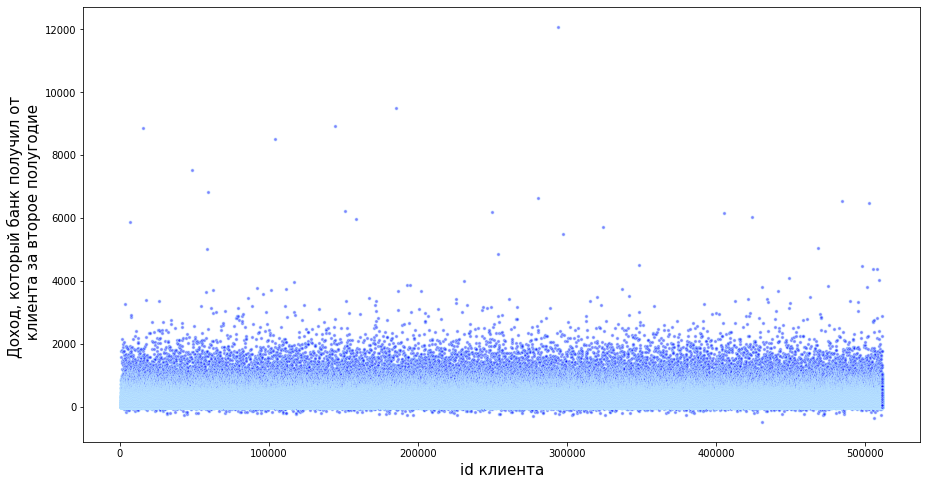

In [83]:
Newtable = Bigtable.rename(columns = {'1gi_smooth_3m': 'Доходность январь',
                                      '2gi_smooth_3m': 'Доходность февраль',
                                      '3gi_smooth_3m': 'Доходность март', 
                                      '4gi_smooth_3m': 'Доходность апрель',
                                      '5gi_smooth_3m': 'Доходность май', 
                                      '6gi_smooth_3m': 'Доходность июнь',
                                      'active': 'Активен ли клиент',
                                      'big_city': 'Город клиента',
                                      'ca_f': 'Флаг наличия текущего счета',
                                      'payroll_f': 'Клиент получает з/п на карту банка'})

plt.scatter(Newtable['cif_id'], Newtable['CLTV'], c = 'blue', alpha = 0.5, s = 10, edgecolors = {'#BCE7FF'})
plt.ylabel('Доход, который банк получил от \n клиента за второе полугодие', fontsize = 15)
plt.xlabel('id клиента', fontsize = 15)
plt.show()

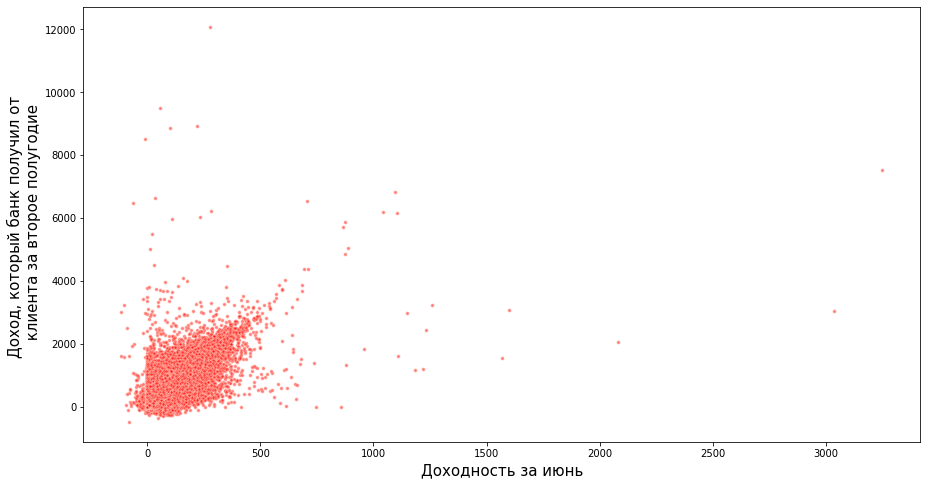

In [84]:
plt.scatter(Newtable['Доходность июнь'], Newtable['CLTV'], c = 'red', alpha = 0.5, s = 10, edgecolors = {'#FFBAAC'})
plt.ylabel('Доход, который банк получил от \n клиента за второе полугодие', fontsize = 15)
plt.xlabel('Доходность за июнь', fontsize = 15)
plt.show()

Теперь рассмотрим на коэффициенты корреляции.

In [85]:
Newtable.drop(columns = 'cif_id', inplace = True)
Newtable = Newtable.dropna()
corr = Newtable.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,Доходность январь,Доходность февраль,Доходность март,Доходность апрель,Доходность май,Доходность июнь,CLTV
Доходность январь,1,0.963759,0.878678,0.820892,0.786275,0.776702,0.710406
Доходность февраль,0.963759,1,0.93359,0.878941,0.819471,0.80739,0.73924
Доходность март,0.878678,0.93359,1,0.966659,0.912201,0.829278,0.756745
Доходность апрель,0.820892,0.878941,0.966659,1,0.960564,0.881362,0.786352
Доходность май,0.786275,0.819471,0.912201,0.960564,1,0.937671,0.811924
Доходность июнь,0.776702,0.80739,0.829278,0.881362,0.937671,1,0.866458
CLTV,0.710406,0.73924,0.756745,0.786352,0.811924,0.866458,1


Как видно из таблицы выше, сильнее всего с откиком скоррелированы значения доходности от клиента за май и июнь.

Рассмотрим насколько хорошо категориальные признаки способны помочь в построении модели.

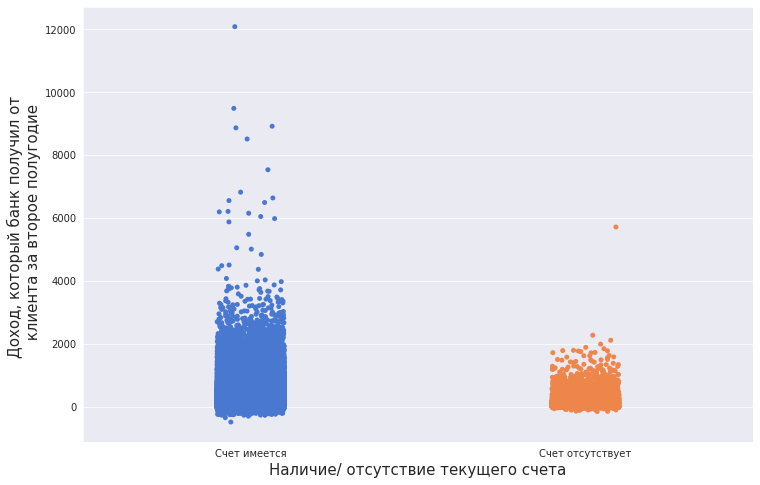

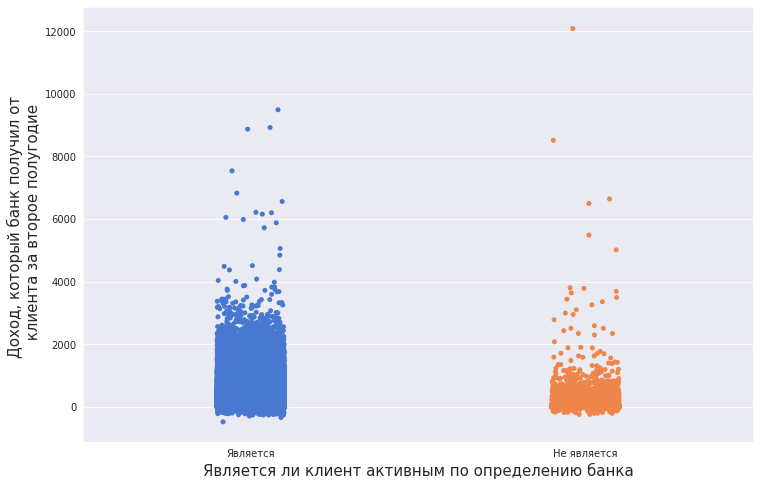

In [86]:
# Подпишем флаги, чтобы было удобнее смотреть на графики
Newtable = Newtable.replace({'Флаг наличия текущего счета': {'0': 'Счет отсутствует', '1': 'Счет имеется'}})
Newtable = Newtable.replace({'Активен ли клиент': {'0': 'Не является', '1': 'Является'}})

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize = (12,8))
    sns.catplot('Флаг наличия текущего счета', 'CLTV', palette = "muted", data = Newtable, ax = ax)
    ax.set_xlabel('Наличие/ отсутствие текущего счета', fontsize = 15)
    ax.set_ylabel('Доход, который банк получил от \n клиента за второе полугодие', fontsize = 15)
    plt.close(2)
    plt.show()
    
    fig, ax = plt.subplots(figsize = (12,8))
    sns.catplot('Активен ли клиент', 'CLTV', palette = "muted", data = Newtable, ax = ax)
    ax.set_xlabel('Является ли клиент активным по определению банка', fontsize = 15)
    ax.set_ylabel('Доход, который банк получил от \n клиента за второе полугодие', fontsize = 15)
    plt.close(2)
    plt.show()    

Именно два представленных выше категориальных признака мы планируем использовать в модели.

## 4. Реализация наивного алгоритма

Зададим функции для отрисовки графиков и вывода метрик.

In [87]:
# Расчет метрики - cредняя абсолютная процентная ошибка
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    # У представленной ниже формулы есть недостаток, - если в массиве y_true есть хотя бы одно значение 0.0,
    # то по формуле np.mean(np.abs((y_true - y_pred) / y_true)) * 100 мы получаем inf, поэтому
    zero_indexes = np.argwhere(y_true == 0.0)
    for index in zero_indexes:
        y_true[index] = 0.01
    value = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return(value)

# Зададим функцию, которая будет выводить на экран значения метрик
def print_metrics(y_test, prediction, model, r2 = False):
    print('Средняя абсолютная ошибка на тестовой выборке -', mean_absolute_error(y_test, prediction))
    print('Средняя медианная ошибка на тестовой выборке -', median_absolute_error(y_test, prediction))
    print('Корень из среднеквадратической ошибки на тестовой выборке -', mean_squared_error(y_test, prediction)**0.5)
    print('Средняя абсолютная процентная ошибка на тестовой выборке -',mean_absolute_percentage_error(y_test, prediction))
    if r2 == True:
        print('Коэффициент детерминации на обучающей выборке -', r2_score(y_train, model.predict(X_train)))

# Зададим функцию для отрисовки графиков
def residuals_plots(y_test, prediction, color = 'blue'):
    prediction = np.ravel(prediction)
    y_test = np.ravel(y_test)
    # Рассчитываем ошибки
    errors = prediction - y_test
    errors = np.ravel(errors)
    with sns.axes_style("darkgrid"):
        sns.kdeplot(errors, shade = True, color = color,  kernel = 'gau', alpha = 0.6)
        plt.title('Распределение ошибок модели')
        plt.ylabel('Плотность вероятности', fontsize = 17)
        plt.xlabel('Ошибки', fontsize = 17)
        plt.show()

    plt.scatter(prediction, errors, c = color, alpha = 0.6, s = 6)
    plt.title('График остатков модели')
    plt.xlabel('Предсказанное значение доходности', fontsize = 15)
    plt.ylabel('Исходные остатки', fontsize = 15)
    plt.grid()
    plt.show()

Предположим, что доходность за второе полугодие равна доходности банка от клиента за первое. Попробуем реализовать данный подход ниже.

In [88]:
dataframe_with_sum = dataset_train[['cif_id', 'dlk_cob_date_cod', 'gi_smooth_3m']].groupby(['cif_id', 'dlk_cob_date_cod']).sum()
dataframe_with_sum = dataframe_with_sum.reset_index()

dataframe_with_sum = dataframe_with_sum.rename(columns={"gi_smooth_3m": "CLTV"})

# Датафрейм с данными за вторые полгода
dataframe_with_sum1 = dataframe_with_sum[dataframe_with_sum.dlk_cob_date_cod == 1]
dataframe_with_sum1 = dataframe_with_sum1.drop(columns = 'dlk_cob_date_cod')
dataframe_with_sum1 = dataframe_with_sum1.rename(columns={"CLTV": "CLTV1"})

# Датафрейм с данными за первые полгода
dataframe_with_sum0 = dataframe_with_sum[dataframe_with_sum.dlk_cob_date_cod == 0]
dataframe_with_sum0 = dataframe_with_sum0.drop(columns = 'dlk_cob_date_cod')
dataframe_with_sum0 = dataframe_with_sum0.rename(columns={"CLTV": "CLTV0"})

Средняя абсолютная ошибка на тестовой выборке - 92.24578928381331
Средняя медианная ошибка на тестовой выборке - 35.96512920000001
Корень из среднеквадратической ошибки на тестовой выборке - 195.68248077084675
Средняя абсолютная процентная ошибка на тестовой выборке - 646970.995777325


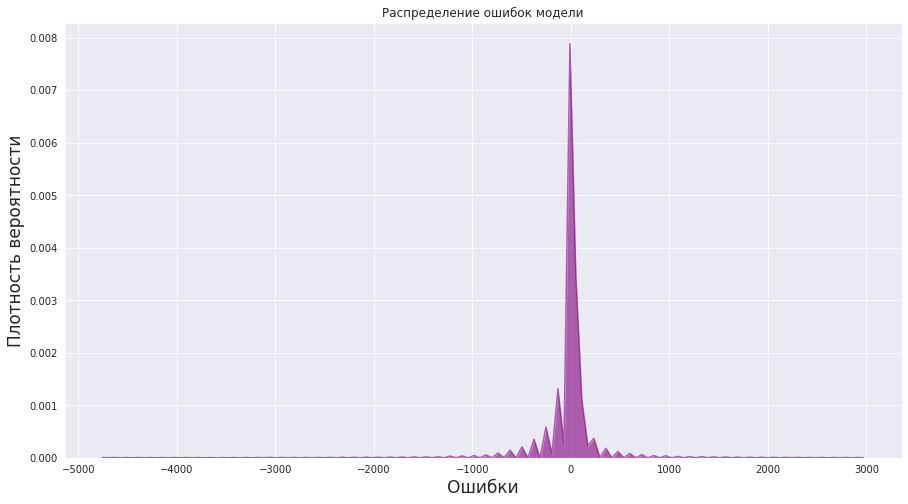

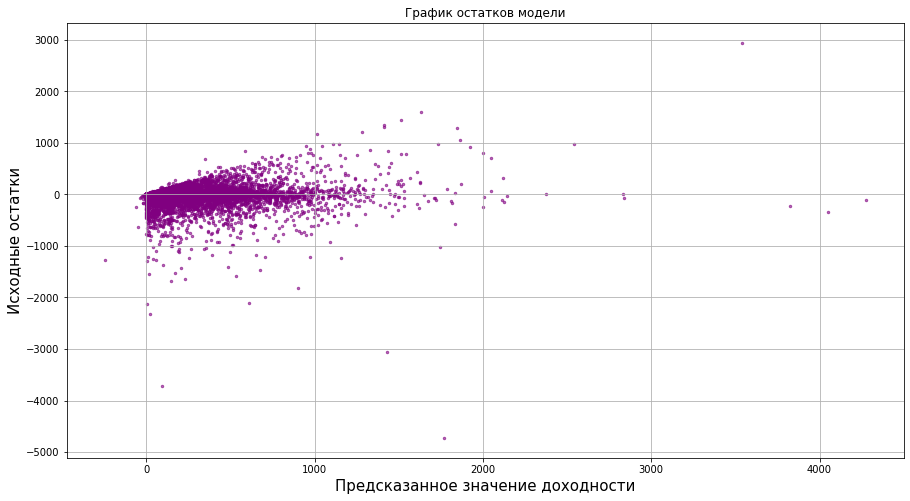

In [89]:
d_dataset = pd.merge(dataframe_with_sum0, dataframe_with_sum1, on = 'cif_id')

# В качестве проверки используем последние 10 000 объектов в датасете
print_metrics(d_dataset['CLTV1'][-10000:], d_dataset['CLTV0'][-10000:], None, r2 = False)
residuals_plots(d_dataset['CLTV1'][-10000:], d_dataset['CLTV0'][-10000:], color = 'purple')

## 5. Реализация окончательной модели

In [72]:
# Декодируем категориальный признак
cat_data = pd.DataFrame(Bigtable[['active', 'ca_f']])
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(cat_data.T.to_dict().values())

# Нам придется подправить форму матриц
encoded_data = np.array(encoded_data).reshape((-1, 4))

scaler = StandardScaler()
(X_train_num, X_test_num, 
 y_train, y_test) = train_test_split(scaler.fit_transform(Bigtable[['1gi_smooth_3m', '2gi_smooth_3m', '3gi_smooth_3m',
                                                                    '4gi_smooth_3m', '5gi_smooth_3m', '6gi_smooth_3m']]),
                                                              np.array(Bigtable['CLTV']),
                                                              test_size = 0.2,
                                                              shuffle = True,
                                                              random_state = 5)

(X_train_cat, X_test_cat) = train_test_split(encoded_data,
                                             test_size = 0.2,
                                             shuffle = True,
                                             random_state = 5)

# Подготавливаем данные в нужных размерностях
X_train_num = np.array(X_train_num).reshape((len(X_train_num),6))
X_test_num = np.array(X_test_num).reshape((len(X_test_num),6))
X_train_cat = np.array(X_train_cat).reshape((-1, 4))
X_test_cat = np.array(X_test_cat).reshape((-1, 4))

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Объединяем вещественные и категориальные предикторы
X_train = np.hstack((X_train_cat, X_train_num))
X_test = np.hstack((X_test_cat, X_test_num))

Средняя абсолютная ошибка на тестовой выборке - 61.60264549086071
Средняя медианная ошибка на тестовой выборке - 21.146746113057667
Корень из среднеквадратической ошибки на тестовой выборке - 145.70058640340707
Средняя абсолютная процентная ошибка на тестовой выборке - 71120.67059659402


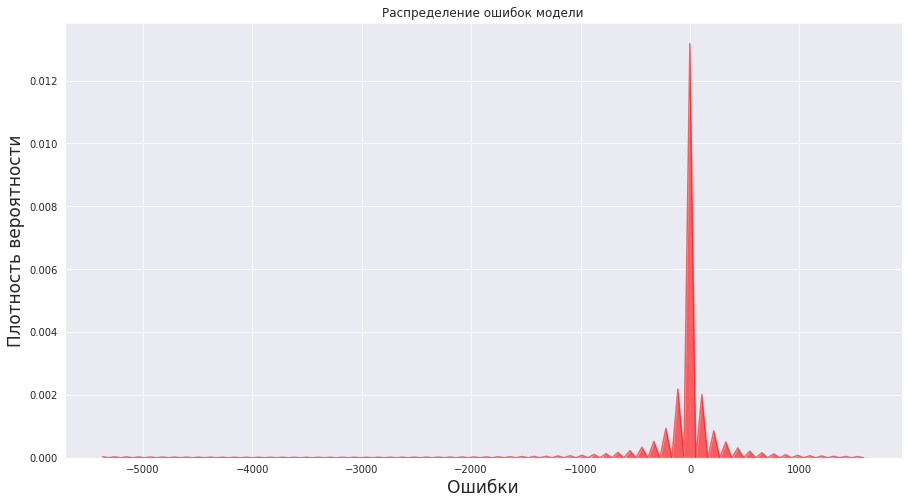

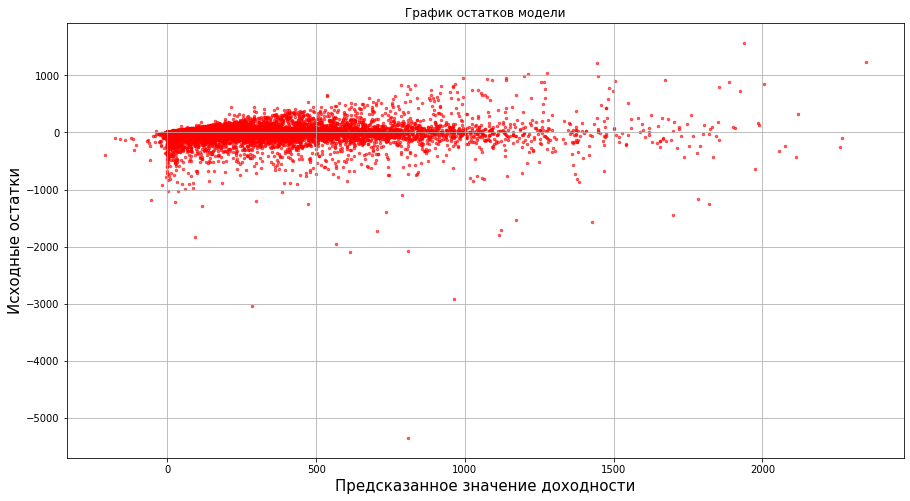

In [73]:
SVRegression = SVR(kernel = 'rbf', gamma = 'scale', C = 200)
SVRegression.fit(X_train, y_train)
SVR_prediction = SVRegression.predict(X_test)

print_metrics(y_test, SVR_prediction, SVRegression, r2 = False)
residuals_plots(y_test, SVR_prediction, color = 'red')

Из графиков видно, что распределение остатков не смещено относительно нуля. При этом частично соблюдается условие гомоскедастичности.

.

.


###### P.S. Некоторые графики и метрики могут отличаться от конечной презентации, так как при обучении модели во время работы над проектом использовался не весь датасет, а только часть с целью ускорения работы. При оформлении данного .ipnb файла модель была обучена на всем объеме данных.